## Imports and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_palette('viridis')
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

protests_data = pd.read_csv('mass_protest.csv')

## About the Dataset

The [protest dataset](https://github.com/datacamp/careerhub-data/tree/master/Mass%20Protest%20Data) contains data from protest events recorded in different continents. It has 31 columns and 17145 rows of data.

In [2]:
protests_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17145 entries, 0 to 17144
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     17145 non-null  int64  
 1   country                17145 non-null  object 
 2   ccode                  17145 non-null  int64  
 3   year                   17145 non-null  int64  
 4   region                 17145 non-null  object 
 5   protest                17145 non-null  int64  
 6   protestnumber          17145 non-null  int64  
 7   startday               15239 non-null  float64
 8   startmonth             15239 non-null  float64
 9   startyear              15239 non-null  float64
 10  endday                 15239 non-null  float64
 11  endmonth               15239 non-null  float64
 12  endyear                15239 non-null  float64
 13  protesterviolence      15758 non-null  float64
 14  location               15218 non-null  object 
 15  pa

# **Cleaning the Dataset**

## Concatenating Date Columns

The following columns will be joined: 

$\checkmark$ `startday`, `startmonth`, and `startyear` to a column called `startperiod`

$\checkmark$ `endday`, `endmonth`, and `endyear` to a column called `endperiod`

- However, should any of these columns contain a missing value, the data for that entry will be dropped. As a result, 1906 data entries were dropped.

In [3]:
date_columns = ['startday', 'startmonth', 'startyear', 'endday', 'endmonth', 'endyear']
protests_data.dropna(subset=date_columns, inplace=True)
protests_data[date_columns].isna().sum()

startday      0
startmonth    0
startyear     0
endday        0
endmonth      0
endyear       0
dtype: int64

- To concatenate these columns, the dtypes for these colums will be changed to integers instead of floats.

In [4]:
protests_data[date_columns] = protests_data[date_columns].apply(lambda x: x.astype('int'))
protests_data[date_columns].dtypes

startday      int32
startmonth    int32
startyear     int32
endday        int32
endmonth      int32
endyear       int32
dtype: object

- Finally, we'll concatenate these columns as required.

In [5]:
protests_data['startperiod'] = protests_data['startday'].map(str) + '-'\
        + protests_data['startmonth'].map(str) + '-'\
        + protests_data['startyear'].map(str)

protests_data['endperiod'] = protests_data['endday'].map(str) + '-'\
        + protests_data['endmonth'].map(str) + '-'\
        + protests_data['endyear'].map(str)

- Now, these columns can be set to be of `datetime` data types 

In [6]:
protests_data['endperiod'] = pd.to_datetime(protests_data['endperiod'], 
                                            format='%d-%m-%Y')

protests_data['startperiod'] = pd.to_datetime(protests_data['startperiod'],
                                              format='%d-%m-%Y')

## Removing Columns

- With the created `startperiod` and `endperiod` columns, we can now remove the unnecessary columns. Remaining columns after dropping some columns will be 17.

In [7]:
col_drop = ['year', 'protesterdemand2', 'protesterdemand3', 'protesterdemand4', 'stateresponse2', 
            'stateresponse3', 'stateresponse4','stateresponse5', 'stateresponse6', 'stateresponse7',
           'startyear', 'startmonth', 'startday', 'endyear', 'endmonth', 'endday']

protests_data.drop(col_drop, axis=1, inplace=True)
protests_data.shape

(15239, 17)

## Handling Missing Values

- Before handling missing values we check the dataset. There are two `datetime` columns, one float column, four integer columns and ten object columns. Out of these columns, it is evident that only the `object` columns contain missing values.

In [8]:
protests_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15239 entries, 0 to 17141
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     15239 non-null  int64         
 1   country                15239 non-null  object        
 2   ccode                  15239 non-null  int64         
 3   region                 15239 non-null  object        
 4   protest                15239 non-null  int64         
 5   protestnumber          15239 non-null  int64         
 6   protesterviolence      15239 non-null  float64       
 7   location               15218 non-null  object        
 8   participants_category  9887 non-null   object        
 9   participants           15227 non-null  object        
 10  protesteridentity      14684 non-null  object        
 11  protesterdemand1       15238 non-null  object        
 12  stateresponse1         15208 non-null  object        
 13  s

- To handle these columns, the null values will be replaced with the string `"unspecified"`.

In [9]:
object_cols = protests_data.select_dtypes('object').columns
protests_data = protests_data.fillna('unspecified')
protests_data.isna().sum()

id                       0
country                  0
ccode                    0
region                   0
protest                  0
protestnumber            0
protesterviolence        0
location                 0
participants_category    0
participants             0
protesteridentity        0
protesterdemand1         0
stateresponse1           0
sources                  0
notes                    0
startperiod              0
endperiod                0
dtype: int64

## Extracting Kenya's Data

The data from Kenya will be used for analysis later on. 

In [10]:
kenyan_protests = protests_data[protests_data.country=='Kenya']
print(kenyan_protests.head(2))

               id country  ccode  region  protest  protestnumber  \
10064  5011990001   Kenya    501  Africa        1              1   
10065  5011990002   Kenya    501  Africa        1              2   

       protesterviolence location participants_category participants  \
10064                0.0  Nairobi               100-999          100   
10065                0.0  Nairobi            5000-10000        >7000   

         protesteridentity             protesterdemand1 stateresponse1  \
10064  university students  political behavior, process         ignore   
10065  university students  political behavior, process         ignore   

                                                 sources  \
10064  yard to aid inquiry into kenya minister s deat...   
10065  yard to aid inquiry into kenya minister s deat...   

                                                   notes startperiod  \
10064  also on sunday, about 100 students demonstrate...  1990-02-18   
10065  more than 7,000 student

## Conclusion on Cleaning Data

Note that the steps performed are not the final steps for cleaning this data. More cleaning will be done as per the requirement when doing further analysis.

# **World Analysis**

## Issues to Assess:

1. Countries with highest and lowest number of protests
2. Regions with highest and lowest number of protests
3. Longest and shortest protests
4. The frequent participants' category
5. Count of violent and no violence protests
6. What is the most protest reason based on protest demands

$\checkmark$ Disclaimer: Conclusion arrived at is done based on the cleaned dataset.

## Distribution of Protests

- Most countries have recorded protests numbers less than 400 and a few above 400. There are also no country with no recorded case of protest. 

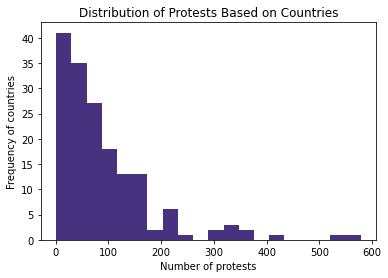

In [13]:
number_protest = protests_data.country.value_counts()

number_protest.plot(kind='hist', bins=20)
plt.xlabel('Number of protests')
plt.ylabel('Frequency of countries')
plt.title('Distribution of Protests Based on Countries');

## Top Ten and Bottom Ten Countries

1. Based on number of protests, all the countries represented in the dataset has recorded atleast a protest.

- United Kingdom lead with over 500 protests. 

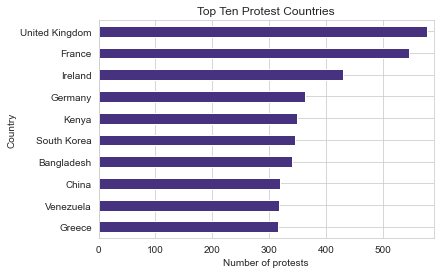

In [15]:
sns.set_style('whitegrid')
number_protest.head(10).sort_values().plot(kind='barh')
plt.margins(0.02)
plt.xlabel('Number of protests')
plt.ylabel('Country')
plt.title('Top Ten Protest Countries');

- Qatar and South Sudan have only one case each of reported violence.

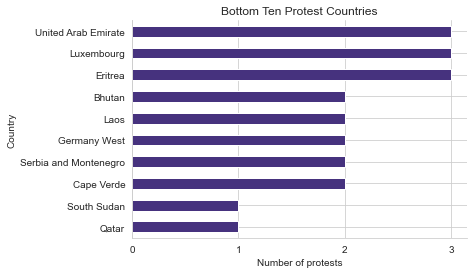

In [16]:
number_protest.tail(10).sort_values().plot(kind='barh')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Number of protests')
plt.ylabel('Country')
plt.title('Bottom Ten Protest Countries')
sns.despine(right=True);

## Region Protest

- The Europe region accounts for more than 30% of the protest frequency while the Oceania region accounts for about 0.3% of the protest frequency.

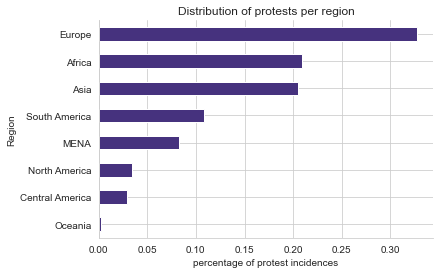

In [18]:
region_protests = protests_data.region.value_counts(normalize=True)

region_protests.sort_values().plot(kind='barh')
sns.despine(right=True)
plt.xlabel('percentage of protest incidences')
plt.ylabel('Region')
plt.title('Distribution of protests per region');

## Protest Duration

- Morroco recorded the highest number of days of protest with over 900 days. 

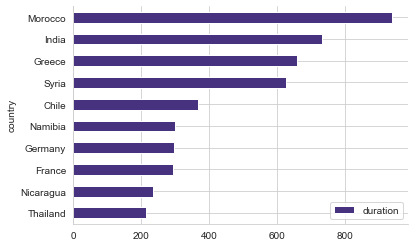

In [28]:
protests_data['duration'] = (protests_data.endperiod - protests_data.startperiod).dt.days
protest_duration = protests_data[protests_data.columns].sort_values(by='duration', ascending=False)

du_dt = protest_duration[['duration', 'country']]\
    .set_index(['country'])\
    .head(10)\
    .sort_values(by='duration')

du_dt.plot(kind='barh')
sns.despine(right=True);

- Out of the over 15000 entries in the data, about 2036 entries have days above zero. This could be as a result of no records of specific time records in terms of hours, minutes and seconds. 

- Out of the 2036 entries, 729 entries are recorded to have a one day protest. My assumption is, we cannot have zero days when already there was a protest reported. Therefore, the zero values will be replaced with ones. (I have considered the bias factor introduced.)

## Category of Participants

- The `unspecified` category has the highest frequency while participants in the categories `5000-10000` and `1000-1999` constitute less than 5% of the participant categories.

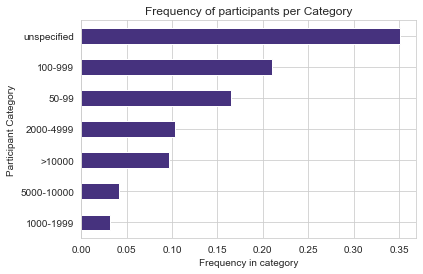

In [30]:
protest_categ = protests_data\
    .participants_category\
    .value_counts(normalize=True)\
    .sort_values()
ax = protest_categ.plot(kind='barh')
ax.set(ylabel='Participant Category', 
       xlabel='Frequency in category',
      title='Frequency of participants per Category');

- With NLP, the `unspecified` category can be broken down into other groups. Check sentimental analysis of protest data.

In [61]:
protests_data[protests_data.participants_category == 'unspecified'].notes

0        canada s railway passenger system was finally ...
1        protestors were only identified as young peopl...
2        the queen, after calling on canadians to remai...
3        canada s federal government has agreed to acqu...
4        protests were directed against the state due t...
                               ...                        
17131    supreme court ruling on monday gives sir micha...
17132    o neill announces speech for the following day...
17133    students boycotted class in response to propos...
17134    protesting against a proposed six month delay ...
17135    protesting gov ts deal w australia over asylum...
Name: notes, Length: 5352, dtype: object

## Protestor Demand

- More than 60% of the protester demand was as a result of political behavior or process. Unspecified reasons accounted for a negligible percentage. 

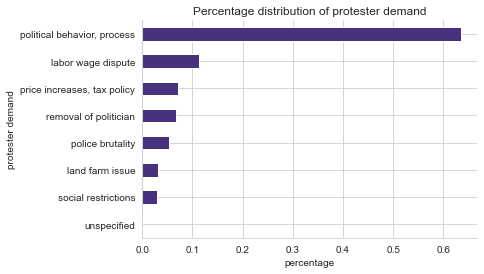

In [34]:
protest_demand = protests_data.protesterdemand1.value_counts(normalize=True)
protest_demand.sort_values().plot(kind='barh')
plt.title('Percentage distribution of protester demand')
plt.xlabel('percentage')
plt.ylabel('protester demand')
sns.despine(right=True);

## State Response

- According to the data, more than 50% of state response to protest was to ignore the protesters. About 25% of the response by states was crowd dispersal. The rest form of response were below 10%.

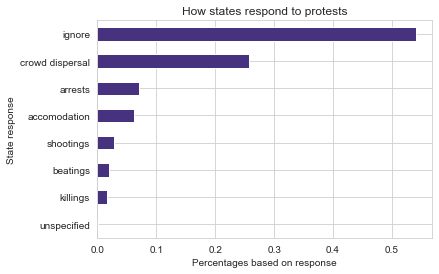

In [35]:
protests_data.stateresponse1.value_counts(normalize=True)\
    .sort_values() \
    .plot(kind='barh')
plt.ylabel('State response')
plt.xlabel('Percentages based on response')
plt.title('How states respond to protests');

## Violent or Non-Violent Protest?

- Almost 74% of the protests were non-violent.

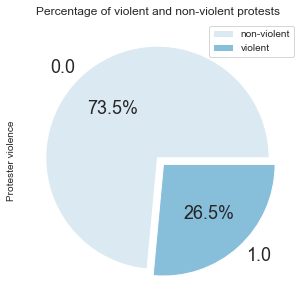

In [65]:
protest_viol = protests_data.protesterviolence.value_counts()
colors = sns.color_palette('RdBu')[3:]
plt.subplots(figsize=(5, 7))
protest_viol.plot(kind='pie', colors=colors, autopct='%.1f%%', 
                  fontsize=18, explode=[0.03, 0.05])
plt.title('Percentage of violent and non-violent protests ')
plt.legend(('non-violent', 'violent'))
plt.ylabel('Protester violence');

# **Kenya Analysis**

7. Narrow into Kenya
    1. Trend of protests over the year
    2. What is the most common reason for protest
    3. What is the common response by state
    4. Longest and shortest protest
    5. Location where most protest happen
    6. How do people participate based on participants category
    7. Identity of the most protesters
    8. Frequency of violent protests
    9. By looking at the notes, can we determine the cause, reason, outcome of the protest.
    
- Protest data from Kenya will be used to provide insight about protest in the country and later on for model building.

In [ ]:
kenya.sample()

## Trend of protests over the year. 

- From the dataset, the first strike is recorded on 18th of February 1990 while the last strike was recorded on the 20th of September 2019. From the breakdown of the protests timespan, we don't include month because it gives an unclear picture of the time span. 

- On average Kenya experience about 12 protests per year (Maybe a protest a month!)

In [ ]:
p_start = kenya.startperiod.min()
p_end = kenya.endperiod.max()
p_span = p_end - p_start
p_years = p_end.year - p_start.year
avg_protest = int(kenya.protest.sum() / p_years)


print('''first protest: {} 
last protest: {}
protest span (days): {} days
protest span (years): {} years
average of {} protests per year'''.format(p_start.strftime('%Y-%m-%d'),
                                         p_end.strftime('%Y-%m-%d'),
                                         p_span.days, p_years, avg_protest))

**Protest Trends over time**

- Let's now plot some graphs. 

- For the 29 years, majority of the months recorded protests incidences below five (some recording zero incidences). However, there are in certain years the protest reported per month exceed five with a month in 2018 recording over 25 protests.

In [ ]:
kenya.resample('M', on='startperiod').protest.count().plot()
plt.ylabel('Protest incidences')
plt.xlabel('Years')
plt.title('Monthly protest incidences')

- In 2015 there were over 140 incidences of reported protests.
- In 1994 and 2011, there were no incidence of reported protests. 
- Most years recorded protests incidence below 40

In [ ]:
kenya.resample('Y', on='startperiod').protest.count().plot()
plt.ylabel('Protest incidences')
plt.xlabel('Years')
plt.title('Yearly protest incidences');

## Protests Duration

- Just like from the previous duration calculation, we can't have zero days. Therefore any value that has zero days will be reassigned the value 1.

In [ ]:
kenya['duration'] = kenya.endperiod - kenya.startperiod
print(f'minimum duration: {kenya.duration.min()}')

kenya.duration.replace(timedelta(days=0), timedelta(days=1), inplace=True)

In [ ]:
long_protest = kenya.duration.max().days
short_protest = kenya.duration.min().days

print(f'''longest protest: {long_protest} days
shortest protest: {short_protest} day ''')

- Approximately 94% of the protests occurred in 1 day. Apart from the 1 day, 2 days and 4 days, the remaining protest days were only record as one incidence.

In [ ]:
kenya.duration.value_counts(normalize=True) * 100

## Protester Demands 

- Seems like there is a reason for protest in Kenya, with no protest categorized as unclassified.
- Majority of the protests are for political behavior and process (about 43%) 

In [ ]:
(kenya.protesterdemand1.value_counts(normalize=True)*100)\
        .sort_values()\
        .plot(kind='barh')

plt.xlabel('Percentage of protester demands')
plt.ylabel('protest demand')
plt.title('Protester Demands in percentages');

## State Response 

- More that 40% of state response is to ignore the protester demands. 
- About 38% of the response is crowd dispersal. 
- Beatings and killings are below 1% each

In [ ]:
(kenya.stateresponse1.value_counts(normalize=True)*100)

In [ ]:
(kenya.stateresponse1.value_counts(normalize=True)*100)\
        .sort_values()\
        .plot(kind='barh')
plt.xlabel('Percentage of State response')
plt.ylabel('State Response')
plt.title('State Response in percentages');

## Participant Category

- About 45% of the protesters were in a group of 50 to 99 participants.
- About 40% were a group of 100-999.
- Larger groups, that is, 5000 and more share a combined percentage of about 3%
- About 1.5% of the groups are unspecified.

In [ ]:
(kenya.participants_category.value_counts(normalize=True)*100)\
        .sort_values()\
        .plot(kind='barh')

plt.xlabel('Percentage of participants')
plt.ylabel('Group size')
plt.title('Percentage of participants in each category')

## Violent or Peaceful Protests



In [ ]:
plt.subplots(figsize=(5, 5))
colors = sns.color_palette('RdBu')[3:]
kenya.protesterviolence.value_counts().plot(kind='pie', autopct='%.1f%%', colors=colors)
plt.title('Percentage of violent and non-violent protests ')
plt.legend(('non-violent', 'violent'))
plt.ylabel('');

## Location where most protest happen

- There are over 150 unique locations. 
- Question will be answered once enough insight is gained about NLP.

## Protesters Identity

- Will be covered later on

## Sentiment Analysis

- Will be covered later on

# Model Building



## Model Building World

Let's build a classifier model that can predict if a protest is violent or non-violent.

- With this data, can we predict if a protest will be non-violent or violent.
- 
- The following columns will be dropped: 'id', 'ccode', 'startperiod', 'endperiod', 'notes', 'sources', 'location', 'participants', 'protesteridentity'

In [ ]:
rem = ['id', 'ccode', 'startperiod', 'endperiod', 'notes', 'sources', 'location', 'participants', 'protesteridentity']

protests.drop(rem, axis=1, inplace=True)

- Encoding the values to numerical data types as required by sklearn.

In [ ]:
columns = ['country', 'participants_category', 'protesterdemand1', 'stateresponse1', 'region']

def cat_encode(df, columns):
    for i in columns:
        entry = df[i].unique()
        repl = np.arange(len(entry))
        new = df[i].replace(entry, repl, inplace=True)
    return new

cat_encode(protests, columns)

- There is no zero days in duration so we change the zeros to ones

In [ ]:
protests.duration.replace(0, 1, inplace=True)

In [ ]:
protests.info()

- Creating arrays of feature and targets: The column protest is also dropped because it only contains one unique value.

In [ ]:
X = protests.drop(['protesterviolence', 'protest'], axis=1).values
y = protests.protesterviolence.values

X.shape, y.shape

- Splitting the data into training and test sets

In [ ]:
X_train, X_test, y_train, y_test = \
            train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

- Creating a pipeline

In [ ]:
steps = [('scaler', StandardScaler(with_mean=False)), ('classifier', SVC())]
pipeline = Pipeline(steps)

- Training the pipeline

In [ ]:
pipeline.fit(X_train, y_train)

- Getting predictions and obtaining the classification report

In [ ]:
ypred = pipeline.predict(X_test)

In [ ]:
print(classification_report(y_test, ypred))

- Everything here: With some hyperparameter tunning, classifier achieves an accuracy of 80% (previously, 77%).

In [ ]:
X = protests.drop(['protesterviolence', 'protest'], axis=1).values
y = protests.protesterviolence.values
X_train, X_test, y_train, y_test = \
            train_test_split(X, y, random_state=42, test_size=0.15, stratify=y)

steps = [('scaler', StandardScaler(with_mean=False)), ('classifier', SVC(gamma=0.1, C=100))]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
ypred = pipeline.predict(X_test)
print(classification_report(y_test, ypred))

- Trying other classifiers without tunning:
    - knn gives 80% accuracy without tunning
    - logistic regression yields 74%.
    
- The model is subject to modification as more knowledge comes to light

In [ ]:
steps = [('scaler', StandardScaler(with_mean=False)), ('classifier', LogisticRegression())]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
ypred = pipeline.predict(X_test)
print(classification_report(y_test, ypred))

In [ ]:
test_2 = pd.DataFrame({'country': np.random.randint(0, 167, size=513),
                       'region': np.random.randint(0, 7, size=513),
                       'protestnumber': np.random.randint(1, 144, size=513),
                       'protesterviolence': np.random.randint(0, 2, size=513),
                       'participant_category': np.random.randint(0, 7, size=513),
                       'protesterdemand1': np.random.randint(0, 8, size=513),
                       'stateresponse1': np.random.randint(0, 8, size=513),
                       'duration': np.random.randint(1, 10, size=513)})

In [ ]:
test_2.head(2)

In [ ]:
X_test2 = test_2.drop('protesterviolence', axis=1).values
y_test2 = test_2.protesterviolence.values

steps = [('scaler', StandardScaler(with_mean=False)), ('classifier', SVC(gamma=0.1, C=100))]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

y_pred2 = pipeline.predict(X_test2)
print(classification_report(y_test2, y_pred2))